In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import OrderedDict
sns.set_style("whitegrid", {'axes.grid' : False})

import os


# Import data

In [5]:
# merged should be a file with the Wikipedia links on the web alongside the ORES topics.

merged = pd.read_parquet("/scratch/venia/web2wiki/data/en_shares_merged2.parquet")
ORES = merged[["title","topic_leaf","qid"]].drop_duplicates()
metadata = pd.read_parquet("/scratch/venia/web2wiki/data/en_wikilinks_domain_counts.parquet/")

In [5]:
metadata2 = metadata.groupby("title")["domain"].nunique()

In [6]:
metadata2 = metadata2.reset_index().sort_values(by = "domain",ascending=False)
metadata2 = metadata2.merge(ORES, on = "title")

In [7]:
unique_domains = metadata2.groupby("title")["domain"].nunique()

In [10]:
df = pd.read_parquet("/scratch/venia/web2wiki/data/en_page_rank_2022-01.parquet")
df = df.rename(columns={"item_id":"qid"})

In [12]:
reddit_counts = pd.read_parquet("/scratch/venia/web2wiki/data/reddit_wikipedia_counts.parquet/")
reddit_counts = reddit_counts.rename(columns={"title_final":"title"})
reddit_counts = reddit_counts.rename(columns={"count":"reddit_count"})

### Create the in links

In [13]:
in_links = pd.read_parquet("/scratch/venia/web2wiki/data/enwiki_inlinks_2022-01.parquet")
in_links = in_links.rename(columns={"target_qid":"qid"})
#.read.csv("/dlabdata1/orphans/data/wiki_graphs/enwiki_links_2022-01.csv",header =True)

In [14]:
in_links = in_links.rename(columns={"count":"in_links"})

## Merge data and create dfs

In [15]:
metadata2.head

<bound method NDFrame.head of                                          title  domain  \
0                                  HTTP cookie   10699   
1                                United States    5912   
2                                    Main Page    4521   
3                   Search engine optimization    3759   
4           General Data Protection Regulation    3375   
...                                        ...     ...   
1930706                        Fire in Stubble       1   
1930707                 Fire in Your New Shoes       1   
1930708                          Fire in anger       1   
1930709                       Fire in my mouth       1   
1930710  Fire in the Hole (Silver Dollar City)       1   

                      topic_leaf        qid  
0                      Computing    Q178995  
1                  North_America        Q30  
2                        History      Q5296  
3                     Technology    Q180711  
4        Politics_and_government   Q1172506

In [16]:
t = metadata2.merge(reddit_counts,on="title", how = "left")
t = in_links.merge(t, on = "qid", how = "right")

In [17]:
t = t[t["title"] != "Main Page"]
t = t[t["title"] != ""]

In [18]:
t = t.rename(columns = {"in_links":"In-links", "domain": "Web invocations", "total_views":"Total views", "reddit_count":"Reddit invocations"})

In [19]:
# t["cuts"]=pd.qcut(t["Total views"], q=np.arange(0,101) / 100,labels=False)


In [20]:
t["ratio"] = t["Web invocations"]/t["In-links"]
# t["ratio2"] = t["domain"]/t["In-links"]

t["reddit_ratio"] = t["Reddit invocations"]/t["In-links"]

t["reddit_wiki_ratio"] = t["Web invocations"]/t["Reddit invocations"]


In [21]:
t = t.merge(unique_domains,left_on = "title",right_index=True, how = "left")

In [22]:
t2 = t[t["In-links"]>5]

In [23]:
# t2.sort_values(by = "ratio2",ascending=False).head(10)

In [3]:
# fig,ax=plt.subplots()
# to_plot = t2[t2["domain"]>434]
# # to_plot = to_plot[(to_plot["domain"]< 5000) & (to_plot["Reddit invocations"]<40000)]
# ax.scatter(to_plot["domain"], to_plot["Reddit invocations"])
# ax.set_yscale('log')
# ax.set_xscale('log')

In [44]:
print(t2.sort_values(by="ratio",ascending=False).dropna(subset = ["ratio","Reddit invocations"]).head(10).append(t2.sort_values(by="reddit_ratio",ascending=False).dropna(subset = ["reddit_ratio"]).head(10))[["title","In-links","Web invocations","Reddit invocations"]].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                              title &  In-links &  Web invocations &  Reddit invocations \\
\midrule
                 Pomodoro Technique &       7.0 &             1506 &              2017.0 \\
                            English &       9.0 &             1258 &                38.0 \\
                           New York &       9.0 &              637 &                20.0 \\
            List of ISO 639-1 codes &       9.0 &              582 &               162.0 \\
      Betteridge's law of headlines &       6.0 &              319 &             12223.0 \\
        Table of keyboard shortcuts &       8.0 &              408 &                 3.0 \\
                         Bus factor &       6.0 &              276 &               640.0 \\
              Rubber duck debugging &       8.0 &              355 &              2502.0 \\
                 Crossing the Chasm &       9.0 &              343 &                69.0 \\
                              JSONP &   

/tmp/ipykernel_1405342/3184480619.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  print(t2.sort_values(by="ratio",ascending=False).dropna(subset = ["ratio","Reddit invocations"]).head(10).append(t2.sort_values(by="reddit_ratio",ascending=False).dropna(subset = ["reddit_ratio"]).head(10))[["title","In-links","Web invocations","Reddit invocations"]].to_latex(index=False))
/tmp/ipykernel_1405342/3184480619.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(t2.sort_values(by="ratio",ascending=False).dropna(subset = ["ratio","Reddit invocations"]).head(10).append(t2.sort_values(by="reddit_ratio",ascending=False).dropna(subset = ["reddit

In [24]:
t.sort_values(by = "Web invocations").dropna(subset = ["Reddit invocations"]).tail(5)

,qid,In-links,title,Web invocations,topic_leaf,Reddit invocations,ratio,reddit_ratio,reddit_wiki_ratio,domain
5,Q668,96293.0,India,2759,South_Asia,312.0,0.028652,0.003240,8.842949,1
4,Q1172506,330.0,General Data Protection Regulation,3375,Politics_and_government,914.0,10.227273,2.769697,3.692560,1
3,Q180711,441.0,Search engine optimization,3759,Technology,2474.0,8.523810,5.609977,1.519402,1
1,Q30,181749.0,United States,5912,North_America,1623.0,0.032528,0.008930,3.642637,1
0,Q178995,336.0,HTTP cookie,10699,Computing,288.0,31.842262,0.857143,37.149306,1


In [25]:
from scipy.stats import pearsonr

In [ ]:

cs = ["Web invocations", "Reddit invocations", "In-links"]
ttttt = t.dropna(subset = cs)
for col1 in cs:
    for col2 in cs:
        print(col1, col2, pearsonr(ttttt[col1], ttttt[col2]))

In [27]:
t =  t.rename(columns = {"Web invocations": "Web references", "Reddit invocations": "Reddit shares"})

In [28]:
heatmap_data = t[["Web references", "Reddit shares", "In-links"]].corr()

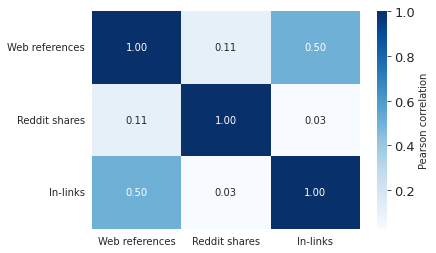

In [29]:
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, cmap = "Blues",cbar_kws={'label': 'Pearson correlation'},ax = ax,annot=True, fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)

# ax.set_xlabel("True")
# ax.set_ylabel("")
# plt.savefig("/scratch/venia/web2wiki/visuals/reddit_wiki_features_correlation2.pdf",dpi = 300, bbox_inches="tight")

In [30]:
web_inlinks = t.groupby("In-links")["Web references"].sum()

In [31]:
topics = t.groupby("topic_leaf").sum()

In [33]:
topic_distribution = topics / topics.sum()

array([[<AxesSubplot:title={'center':'In-links'}>]], dtype=object)

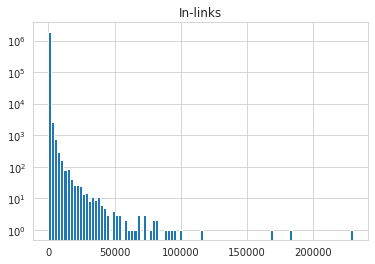

In [60]:
t.hist("In-links",bins = 100, log = True)

In [ ]:
t.hist("Web inovcations",bins = 100, log = True)

In [ ]:
t.hist("Reddit invocations",bins = 100, log = True)

In [62]:
cols = topic_distribution.columns
kl_divergences = []
for col1 in cols:
    for col2 in cols:
        v1 = topic_distribution[col1]
        v2 = topic_distribution[col2]
        score = -(v1 * v2.apply(lambda x: np.log(x))).sum()
        kl_divergences.append((col1,col2,score))

In [63]:
kl = pd.DataFrame(kl_divergences, columns = ["True", "Estimated", "kl-divergence"])

In [64]:
kl = kl.pivot(index = "True", columns = "Estimated")

In [65]:

kl

kl-divergence                                         \
Estimated              In-links Reddit shares Web references    domain   
True                                                                     
In-links               3.457736      3.780267       3.579193  3.482775   
Reddit shares          3.760904      3.450469       3.573666  3.781026   
Web references         3.692209      3.683141       3.553668  3.664075   
domain                 3.525487      3.840397       3.597454  3.498412   
ratio                  3.697555      3.771963       3.605526  3.639769   
reddit_ratio           3.789372      3.497674       3.596648  3.788473   
reddit_wiki_ratio      3.581779      3.773206       3.539818  3.543795   

                                                            
Estimated             ratio reddit_ratio reddit_wiki_ratio  
True                                                        
In-links           3.561289     3.782472          3.531145  
Reddit shares      3.648674     3.489312          3.707513  
Web references     3.585135     3.692379          3.590444  
domain             3.556890     3.830471          3.537461  
ratio              3.573282     3.751278          3.611869  
reddit_ratio       3.632947     3.455423          3.710442  
reddit_wiki_ratio  3.541103     3.765030          3.504484

In [66]:
kl = kl.droplevel(0, axis=1)

In [67]:
kl.columns.name = "True"
kl.index.name = "Estimated"

In [68]:
sns.set(font_scale=1.2)


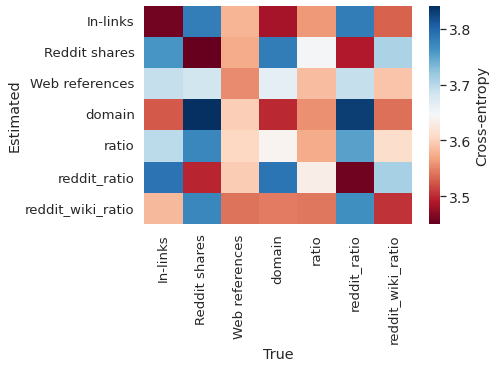

In [69]:
fig, ax = plt.subplots()
sns.heatmap(kl, cmap = "RdBu",cbar_kws={'label': 'Cross-entropy'},ax = ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# ax.set_xlabel("True")
# ax.set_ylabel("")
# plt.savefig("/scratch/venia/web2wiki/visuals/reddit_wiki_features_cross-entropy.pdf",dpi = 300, bbox_inches="tight")

In [38]:
topic_distribution.index = [k.replace("_", " ") for k in topic_distribution.index]

In [39]:
web = topic_distribution[["Web references", "In-links"]]
web["In-links"] = web["Web references"] - web["In-links"]
# web["Page views"] = web["Web inovcations"] - web["Total views"]

/tmp/ipykernel_857162/226093002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web["In-links"] = web["Web references"] - web["In-links"]


In [40]:
reddit = topic_distribution[["Reddit shares", "In-links"]]
reddit["In-links"] = reddit["Reddit shares"] - reddit["In-links"]
# reddit["Page views"] = reddit["Reddit invocations"] - reddit["Total views"]

/tmp/ipykernel_857162/2856611085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit["In-links"] = reddit["Reddit shares"] - reddit["In-links"]


In [41]:
dif = web["In-links"] - reddit["In-links"]
largest_difs = dif.sort_values(ascending=False).head(3).index
smallest_difs = dif.sort_values(ascending=True).head(3).index

In [42]:
sns.reset_orig()

# sns.set_style("whitegrid", {'axes.grid' : False})
import seaborn as sns
sns.set_theme()


In [58]:
temp = temp.iloc[::-1]


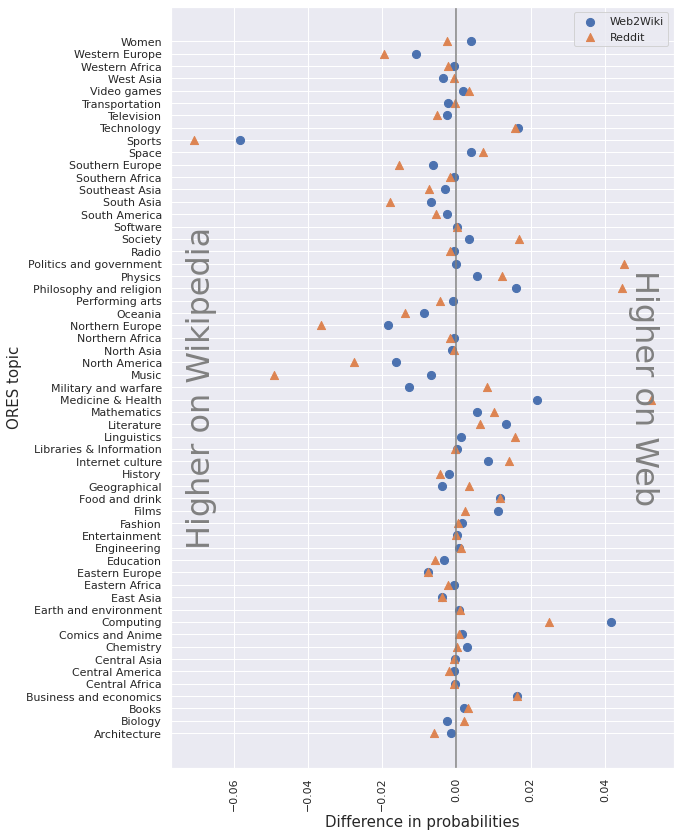

In [62]:
fig, axs = plt.subplots(1,1, figsize = (9,14), sharey=False)

ax = axs
# cols = ["PageRank","Page views"]
cols = ["In-links"]
for col in cols:
    temp = web[col]
    ax.scatter(temp.values,temp.index, label = "Web2Wiki", s = 66)
    
for col in cols:
    temp = reddit[col]
    ax.scatter(temp.values,temp.index, label = "Reddit", marker = "^", s = 66)

#for large,small in zip(largest_difs, smallest_difs):
#    ax.axhline(large, linestyle = "--", color = "tab:blue")
#    ax.axhline(small, linestyle = "--", color = "tab:orange")

ax.axvline(0,color = "gray")
ax.text(.94, 0.5, "Higher on Web", rotation = 270, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)
ax.text(.06, 0.5, "Higher on Wikipedia", rotation = 90, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)

ax.tick_params("x", rotation = 90)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_xlabel("Difference in probabilities",fontsize = 15)
ax.set_ylabel("ORES topic",fontsize = 15)
# ax.set_title("Web vs. Wikipedia In-Links Comparison",fontsize = 15)

plt.savefig("/scratch/venia/web2wiki/visuals/web-reddit_ores_scatter.pdf",dpi = 300, bbox_inches="tight")

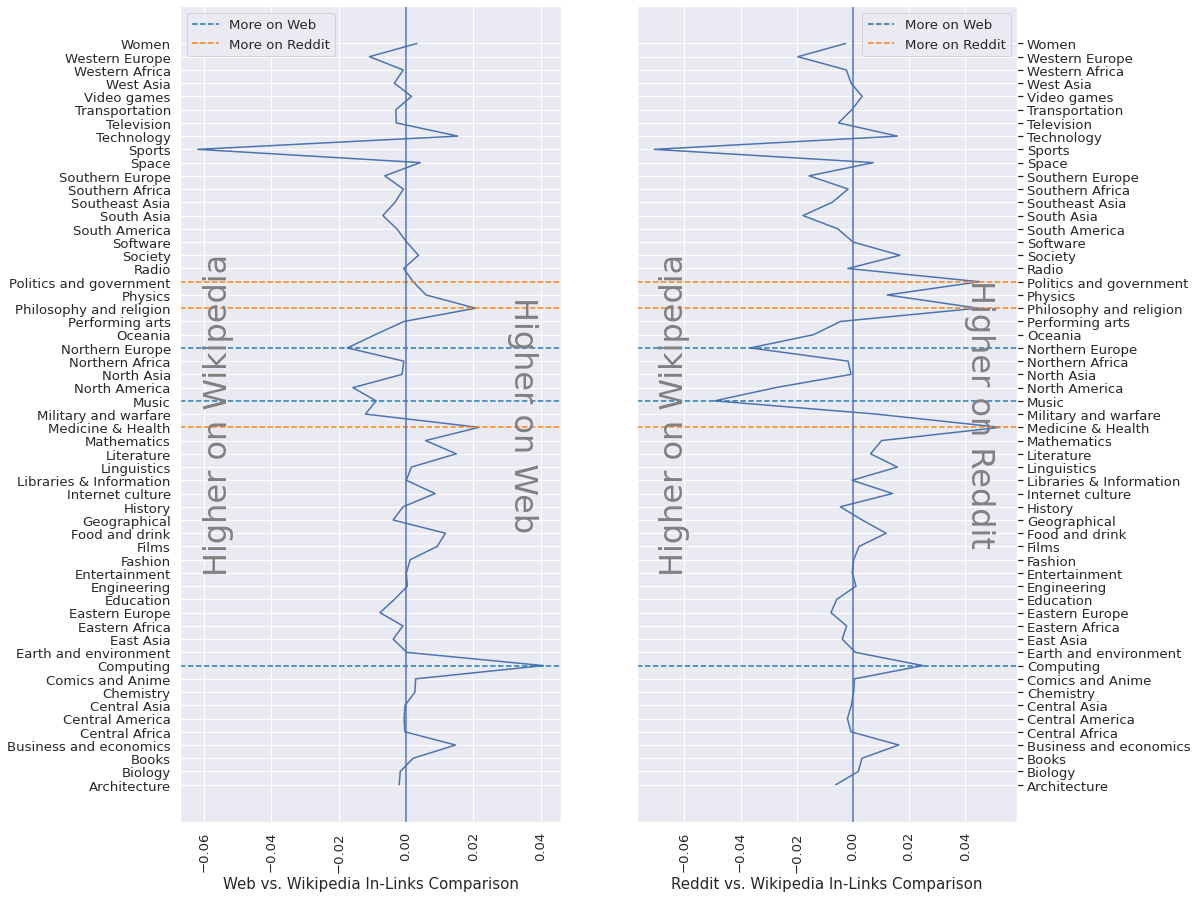

In [389]:
fig, axs = plt.subplots(1,2, figsize = (15,15), sharey=False)

ax = axs[0]
# cols = ["PageRank","Page views"]
cols = ["In Links"]
for col in cols:
    temp = web[col]
    ax.plot(temp.values,temp.index)

for large,small in zip(largest_difs, smallest_difs):
    ax.axhline(large, linestyle = "--", label = "More on Web", color = "tab:blue")
    ax.axhline(small, linestyle = "--", label = "More on Reddit", color = "tab:orange")

ax.axvline(0)
ax.text(.9, 0.5, "Higher on Web", rotation = 270, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)
ax.text(.1, 0.5, "Higher on Wikipedia", rotation = 90, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)

ax.tick_params("x", rotation = 90)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_xlabel("Web vs. Wikipedia In-Links Comparison",fontsize = 15)
# ax.set_title("Web vs. Wikipedia In-Links Comparison",fontsize = 15)

ax = axs[1]

# fig, ax = plt.subplots(figsize = (10,18))

for col in cols:
    temp = reddit[col]
    ax.plot(temp.values,temp.index)
ax.yaxis.tick_right()

for large,small in zip(largest_difs, smallest_difs):
    ax.axhline(large, linestyle = "--",  label = "More on Web", color = "tab:blue")
    ax.axhline(small, linestyle = "--",  label = "More on Reddit", color = "tab:orange")

ax.axvline(0)
ax.text(.9, 0.5, "Higher on Reddit", rotation = 270, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)
ax.text(.1, 0.5, "Higher on Wikipedia", rotation = 90, fontsize = 32, color = "grey", ha = "center", va = "center",transform = ax.transAxes)

ax.tick_params("x", rotation = 90)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_xlabel("Reddit vs. Wikipedia In-Links Comparison",fontsize = 15)
# ax.set_title("Reddit vs. Wikipedia In-Links Comparison",fontsize = 15)

plt.savefig("/scratch/venia/web2wiki/visuals/web_reddit_comparison.pdf",dpi = 300, bbox_inches="tight")

/tmp/ipykernel_3433796/3653410094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit["PageRank"] = reddit["Reddit invocations"] - reddit["PageRank"]


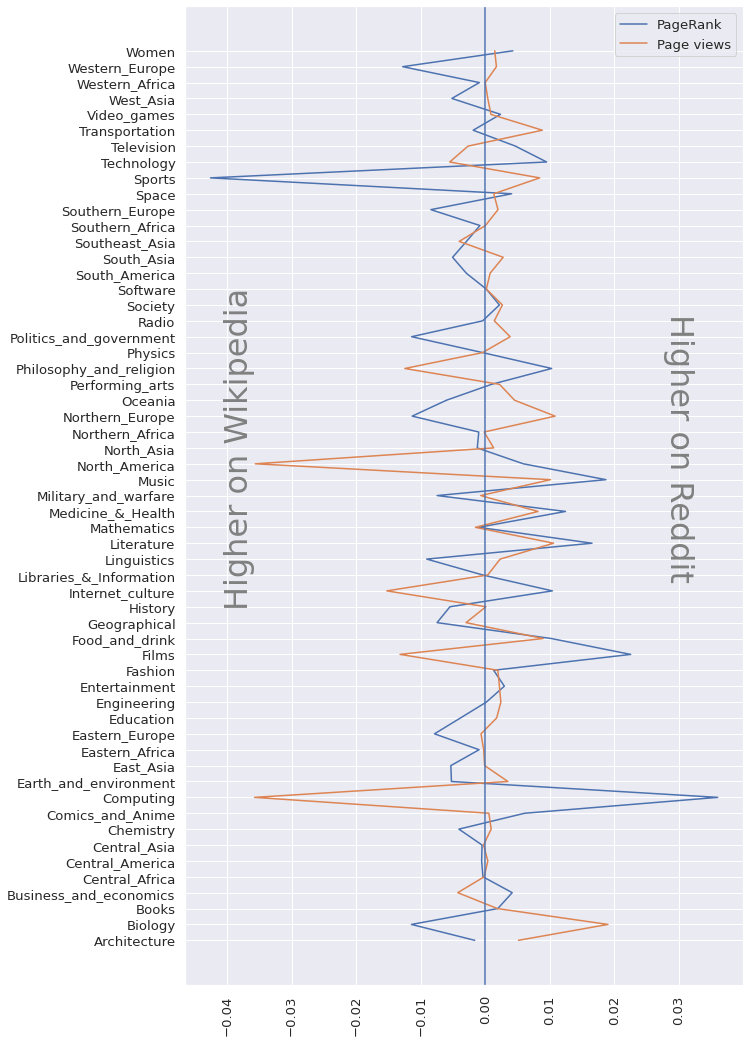

In [268]:
fig, ax = plt.subplots(figsize = (10,18))

cols = ["PageRank","Page views"]

for col in cols:
    temp = web[col]
    ax.plot(temp.values,temp.index, label = col)
    
ax.axvline(0)
ax.text(.03, "North_Asia", "Higher on Reddit", rotation = 270, fontsize = 32, color = "grey", ha = "center", va = "center")
ax.text(-.038, "North_Asia", "Higher on Wikipedia", rotation = 90, fontsize = 32, color = "grey", ha = "center", va = "center")

ax.tick_params("x", rotation = 90)
ax.legend()